# Módulo 4 - Aula 2: SVM Linear - Formulação passo a passo
Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Jesus Paucar -- j236865@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina:
[moodle.lab.ic.unicamp.br/680](https://moodle.ic.unicamp.br/moodle/course/view.php?id=680)

Instituto de Computação - Unicamp 2025

Fonte: https://pythonprogramming.net/svm-in-python-machine-learning-tutorial/

In [1]:
# Importanto algumas bibliotecas básica
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import numpy as np

Vamos definir a classe SVM. Neste exemplo, não somos capazes de lidar com elementos não-lieanrmente separáveis.
O exemplo a seguir não utiliza as Slack Variables nem a formulação de kernel.

In [23]:
class SVM(object):
    def __init__(self,visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)

    def fit(self,data):
        # treinando com os dados
        self.data = data
        # { ||w||: [w,b] }
        opt_dict = {}

        transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]

        all_data = np.array([])
        for yi in self.data:
            all_data = np.append(all_data,self.data[yi])

        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None

        # com passos menores, nossas margens e db serão mais precisas
        step_sizes = [self.max_feature_value * 0.1,
                      self.max_feature_value * 0.01,
                      # point of expense
                      self.max_feature_value * 0.001,]

        # muito custoso
        b_range_multiple = 5 # 5, 10
        # não precisamos dar o mesmo pequeno passo que w
        b_multiple = 5 # 5

        latest_optimum = self.max_feature_value*10  # factor 10

        """
        O objetivo é satisfazer yi(x.w)+ b >= 1 para todos os dados de treinamento, de modo que ||w|| seja mínimo.
        Para isso, começaremos com w aleatório e tentaremos satisfazê-lo com b cada vez maior
        """
        # tornando cada passo cada vez menor para obter um valor preciso
        for step in step_sizes:
            w = np.array([latest_optimum,latest_optimum])

            # nós podemos fazer isso porque é convexo
            optimized = False
            while not optimized:
                for b in np.arange(-1*self.max_feature_value*b_range_multiple,
                                   self.max_feature_value*b_range_multiple,
                                   step*b_multiple):
                    for transformation in transforms:
                        w_t = w*transformation
                        found_option = True

                        # Link mais fraco no SVM fundamentalmente
                        # O SMO (Sequential minimal optimization tenta corrigir isso um pouco
                        # https://en.wikipedia.org/wiki/Sequential_minimal_optimization
                        # yi(xi.w+b) >= 1
                        for i in self.data:
                            for xi in self.data[i]:
                                yi=i
                                if not yi*(np.dot(w_t,xi)+b)>=1:
                                    found_option=False
                        if found_option:
                            """
                            todos os pontos no dataset satisfazem y(w.x)+b>=1 para os valores de w_t, b correntes
                            entao, coloque w,b no dict com ||w|| as key
                            """
                            opt_dict[np.linalg.norm(w_t)]=[w_t,b]

                # depois que w[0] ou w[1]<0 os valores de w vão se repetir por causa das transformações
                # tente avaliar este fato
                # print(w,len(opt_dict)) -> pode ajudar a entender
                if w[0]<0:
                    optimized=True
                    print("optimized a step")
                else:
                    w = w-step

            # ordenando ||w|| para colocar o menor ||w|| na posicao 0
            norms = sorted([n for n in opt_dict])
            # valores ótimos de w,b
            if len(norms) > 1:
                opt_choice = opt_dict[norms[0]]

                self.w=opt_choice[0]
                self.b=opt_choice[1]
                latest_optimum = opt_choice[0][0]+step*2
            else:
                print("not able to optimize")
            # comece com os últimos ótimos (valores iniciais para w)

    def predict(self,features):
        # sign(x.w+b)
        classification = np.sign(np.dot(np.array(features),self.w)+self.b)
        if classification!=0 and self.visualization:
            self.ax.scatter(features[0],features[1],s=200,marker='*',c=self.colors[classification])
        return (classification,np.dot(np.array(features),self.w)+self.b)

    def visualize(self):
        [[self.ax.scatter(x[0],x[1],s=100,c=self.colors[i]) for x in data_dict[i]] for i in data_dict]

        # hyperplane = x.w+b (é uma reta)
        # v = x0.w0+x1.w1+b -> x1 = (v-w[0].x[0]-b)/w1
        # psv = 1     psv line ->  x.w+b = 1  um valor pequeno de b, vamos aumentar depois
        # nsv = -1    nsv line ->  x.w+b = -1
        # dec = 0     db line  ->  x.w+b = 0
        def hyperplane(x,w,b,v):
            # retorna um valor de x2 na linha quando recebe x1
            return (-w[0]*x-b+v)/w[1]

        hyp_x_min= self.min_feature_value*0.9
        hyp_x_max = self.max_feature_value*1.1

        # (w.x+b)=1
        # hiperplano de vetor de suporte positivo
        pav1 = hyperplane(hyp_x_min,self.w,self.b,1)
        pav2 = hyperplane(hyp_x_max,self.w,self.b,1)
        self.ax.plot([hyp_x_min,hyp_x_max],[pav1,pav2],'k')

        # (w.x+b)=-1
        # hiperplano de vetor de suporte negativo
        nav1 = hyperplane(hyp_x_min,self.w,self.b,-1)
        nav2 = hyperplane(hyp_x_max,self.w,self.b,-1)
        self.ax.plot([hyp_x_min,hyp_x_max],[nav1,nav2],'k')

        # (w.x+b)=0
        # db hiperplano de suporte
        db1 = hyperplane(hyp_x_min,self.w,self.b,0)
        db2 = hyperplane(hyp_x_max,self.w,self.b,0)
        self.ax.plot([hyp_x_min,hyp_x_max],[db1,db2],'y--')

[[<matplotlib.collections.PathCollection at 0x7b3c275f0a70>,

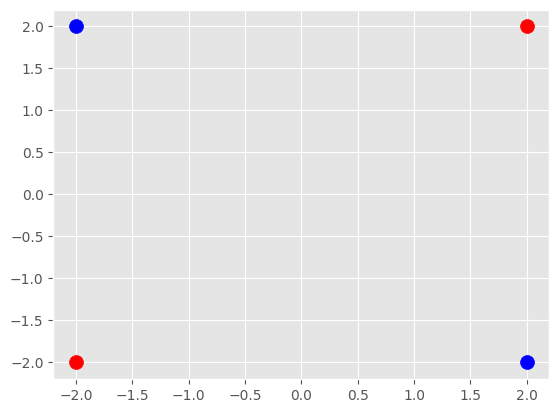

In [26]:
# Alguns dados iniciais para avaliarmos o aprendizado
#data_dict = {-1:np.array([[1,7],[4,3]]),1:np.array([[5,1],[6,-1],[7,3]])}
data_dict = {-1: np.array([[-2,  2], [ 2, -2]]), 1: np.array([[-2, -2], [ 2,  2]])} # XOR Problem
#data_dict = {-1: np.array([[1, 57], [4, 53]]), 1: np.array([[5, 51], [6, 49], [7, 53]])}

fig = plt.figure()
colors = {1:'r',-1:'b'}
ax = fig.add_subplot(1,1,1)

# mostra os dados de treinamento
[[ax.scatter(x[0],x[1],s=100,c=colors[i]) for x in data_dict[i]] for i in data_dict]


optimized a step
optimized a step
optimized a step


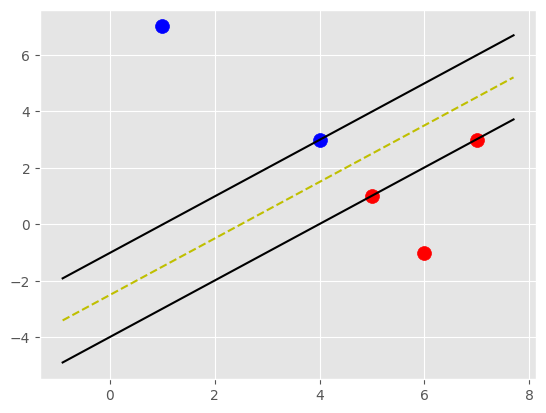

In [25]:
# SVM com Kernel Linear
svm = SVM()
svm.fit(data=data_dict)
svm.visualize()

In [ ]:
# Alguns dados iniciais para avaliarmos o aprendizado
data_dict = {-1:np.array([[1,7],[2,8],[3,8]]),1:np.array([[5,1],[6,-1],[7,3]])}

fig = plt.figure()
colors = {1:'r',-1:'b'}
ax = fig.add_subplot(1,1,1)

# mostra os dados de treinamento
[[ax.scatter(x[0],x[1],s=100,c=colors[i]) for x in data_dict[i]] for i in data_dict]

# Prevendo alguns exemplos de fora do conjunto
# Predict vai retornar o valor da classe e o valor antes da função sign
newdata_dict = dict()
newdata_dict.update({int(svm.predict([3,8])[0]) : [np.array([3,8])]})
newdata_dict.update({int(svm.predict([1,5])[0]) : [np.array([1,5])]})
newdata_dict.update({int(svm.predict([4.0,4.5])[0]) : [np.array([4.0,4.5])]})
newdata_dict.update({int(svm.predict([8,10])[0]) : [np.array([8,10])]})
#print(data_dict)
print(newdata_dict)

fig2 = plt.figure()
bx = fig2.add_subplot(1,1,1)

# mostra os dados de treinamento
# novas previsões
[[bx.scatter(x[0],x[1],s=100,c=colors[i]) for x in newdata_dict[i]] for i in newdata_dict]


Tente aplicar ao conjunto de treinamento um ponto que impeça a separação linear. O que acontece?